<a href="https://colab.research.google.com/github/scottwmwork/DS-Unit-2-Regression-Classification/blob/master/module4/assignment_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 4

## Assignment

- [ ] Watch Aaron Gallant's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Do one-hot encoding. For example, in addition to `quantity`, you could try `basin`, `extraction_type_class`, and more. (But remember it may not work with high cardinality categoricals.)
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your coefficients.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.


## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Clean the data. For ideas, refer to [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide),  a "reference to problems seen in real-world data along with suggestions on how to resolve them." One of the issues is ["Zeros replace missing values."](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values)
- [ ] Make exploratory visualizations.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

To visualize this dataset, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from the previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```

#### Pipelines

[Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/compose.html) explains why pipelines are useful, and demonstrates how to use them:

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:
> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

### Reading
- [ ] [Why is logistic regression considered a linear model?](https://www.quora.com/Why-is-logistic-regression-considered-a-linear-model)
- [ ] [Training, Validation, and Testing Data Sets](https://end-to-end-machine-learning.teachable.com/blog/146320/training-validation-testing-data-sets)
- [ ] [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)
- [ ] [Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)
- [ ] [Statistical Modeling: The Two Cultures](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).



In [12]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module4')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 104, done.
remote: Total 104 (delta 0), reused 0 (delta 0), pack-reused 104
Receiving objects: 100% (104/104), 17.31 MiB | 14.89 MiB/s, done.
Resolving deltas: 100% (41/41), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 92kB 5.6MB/s 
     |████████████████████████████████| 112kB 16.0MB/s 
     |████████████████████████████████| 133kB 39.7MB/s 
     |████████████████████████████████| 57.7MB 564kB/s 
     |████████████████████████████████| 7.1MB 38.7MB/s 
     |████████████████████████████████| 235kB 41.4MB/s 
     |████████████████████████████████| 614kB 38.5MB/s 
     |████████████████████████████████| 225kB 38.8MB/s 
     |████████████████████████████████| 768kB 38.4MB/s 
     |████████████████████████████████| 194kB 41.9MB/s 
     |████████

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

#assert checks if statements after it is true or false. if false it throws an error.
assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [15]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [0]:
#import libraries
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [17]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


#Determine Majority class

In [18]:
y_train = train_labels['status_group']
y_train.value_counts(normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [19]:
#Guess the majority class for every prediction
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
print(len(y_pred))

59400


In [20]:
#Baseline accuracy if we guessed the majority class for every prediction
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.543080808080808

#Do Train/validate/test split


In [21]:
from sklearn.model_selection import train_test_split

X_train = train_features
y_train = train_labels['status_group']

#Randomly takes sample data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.80, test_size=0.20, stratify= y_train, random_state=42)

#Show shapes 
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [0]:
#drop non-numeric features
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

In [23]:
#any nulls?
X_train_numeric.isnull().sum()

id                   0
amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64

In [24]:
#fit logistic regression on train data
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(n_jobs = -1)
model.fit(X_train_numeric, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [25]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_val_numeric)
accuracy_score(y_val, y_pred)

0.5542087542087543

In [26]:
model.score(X_val_numeric, y_val) #Baseline

0.5542087542087543

That Data is not much better (probably because we used train_test_split random data instead of splitting the data via time)

In [27]:
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [28]:
y_pred_proba = model.predict_proba(X_val_numeric)
y_pred_proba

array([[0.50228142, 0.06953975, 0.42817883],
       [0.64800609, 0.09986685, 0.25212706],
       [0.55549719, 0.07820968, 0.36629313],
       ...,
       [0.48762355, 0.08610532, 0.42627113],
       [0.63305002, 0.06597147, 0.30097851],
       [0.27332413, 0.04583417, 0.6808417 ]])

In [29]:
# Recombine X_train and y_train, for exploratory data analysis
train = X_train.copy()
train['status_group'] = y_train

# Now do groupby...
train.groupby('quantity')['status_group'].value_counts(normalize=True)

train['functional'] = (train['status_group']=='functional').astype(int)
train[['status_group', 'functional']]

,status_group,functional
43360,functional,1
7263,functional,1
2486,functional,1
313,non functional,0
52726,functional,1
8558,functional,1
2559,functional,1
54735,functional,1
25763,non functional,0
44540,non functional,0


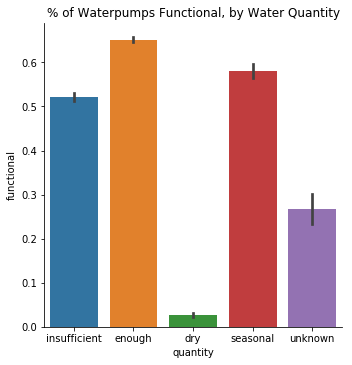

In [30]:
#plot coefficients
sns.catplot(x='quantity', y='functional', data=train, kind='bar')
plt.title('% of Waterpumps Functional, by Water Quantity');

In [37]:
y_pred = model.predict(X_test_scaled)

NameError: ignored

In [36]:
submission.shape, y_pred.shape

((14358, 2), (11880,))

In [35]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)

ValueError: ignored

In [34]:
!head submission-01.csv

head: cannot open 'submission-01.csv' for reading: No such file or directory


In [33]:
if in_colab:
    from google.colab import files
    # Just try again if you get this error:
    # TypeError: Failed to fetch
    # https://github.com/googlecolab/colabtools/issues/337
    files.download('submission-01.csv')

FileNotFoundError: ignored

In [0]:
pip install kaggle

In [0]:
X_test_subset = test_features[features]
X_test_encoded = encoder.transform(X_test_subset)
X_test_scaled = scaler.transform(X_test_encoded)
assert all(X_test_encoded.columns == X_train_encoded.columns)

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/

In [0]:
y_pred = model.predict(X_test_scaled)